# Generative Adversarial Network for Fashion-MNIST
We want to try to generate artificial data - in this example, images of the 10 categories of clothing items. The generated images should be created in such a way that they cannot be distinguished from real images. We use a generator for the creation, analogous to the decoder of an autoencoder, and also generate the codes randomly. To distinguish between real and artificial data, we also use a deep neural network that solves a binary classification problem. This second network is called a discriminator or adversary.

The two parts of the network (generator and discriminator) are trained alternately

# Preparations
## Load Libraries

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Input, MaxPool2D # neue Layers!
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers

2025-02-20 13:40:21.364856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 13:40:21.364905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 13:40:21.366040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 13:40:21.374086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 13:40:22.268488: W tensorflow/compiler/tf2

In [3]:
import tensorflow as tf
tf.random.set_seed(123)
np.random.seed(123)

## Prepare Data
We do the same pre-processing steps as you already know:

In [4]:
# Laden:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_val_images, train_val_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Skalieren:
train_val_images = train_val_images / 255.0

# Aufteilen training / validation
train_images, val_images = train_test_split(
    train_val_images, test_size=0.20, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


We randomly choose 1000 samples to allow for a faster training:

In [5]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(train_images.astype(np.float32)).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

2025-02-20 13:40:25.571034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 13:40:25.604518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 13:40:25.605923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# The Generative Adversarial Network (GAN)
## Model Definition
Next, we define the model. We will choose a coding size of 30, and start off with very similar architectures as we had for the Autoencoder. We use the encoder part for the discriminator, and the decoder part for the generator.

In [6]:
tf.random.set_seed(42)
codings_size = 30

In [7]:
# generator, similar to the decoding part of the Autoencoder
generator = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (30)),
    tf.keras.layers.Dense(7*7*16, activation= 'relu'),
    tf.keras.layers.Reshape(target_shape = (7, 7, 16)),
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(16, kernel_size = (3,3), activation = 'selu', padding = 'same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(1, kernel_size = (3,3), activation = 'sigmoid', padding = 'same'),
])

In [8]:
# discriminator - a typical CNN architecture for a classification task. Here, we have a binary classification task.
discriminator = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the discriminator.
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [9]:
# The overall GAN consists of a generator and a discriminator. 
# For the training process, we set the discriminator to non-trainable, so that when we train the gan,
# only the parameters of the generator will change.
discriminator.trainable = False
gan = tf.keras.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Training / Fitting
To better track the progress of the training, we want to display a few generated images after each epoch. For this, we define this helper function:

In [10]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

The following function alternately trains the `discriminator` and the `generator`.

* To train the `discriminator`, we generate data from random codes using a random number generator via `tf.random.normal`, and "decode" them to images using the `generator`. The real and synthetic data with the corresponding labels are then the training data for the `discriminator`.
* To train the ` generator`, we use random codes and the current state of the `discriminator`. The `generator` should be trained in such a way that the `discriminator` does not recognize the synthetic data, i.e., it (incorrectly) classifies them as real data

In [11]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            
            # phase 1 - training the discriminator
            random_input = tf.random.normal(shape=[batch_size, codings_size])  # random numbers
            generated_images = generator(random_input)  # use discriminator as is
            X_fake_and_real = tf.concat([tf.squeeze(generated_images), X_batch], axis=0)
            # Labels: 0 => synthetic data, 1 => real data
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size, dtype=tf.float64)
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # phase 2 - training the generator
            random_input = tf.random.normal(shape=[batch_size, codings_size])
            # we want to train the generator such that the discriminator thinks the generated images are real!
            y2 = tf.constant([[1.]] * batch_size, dtype=tf.float64)
            gan.train_on_batch(random_input, y2)
            
        # extra code — plot images during training
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

The following instruction will train this GAN over 5 epochs - this is typically enough to see some interesting things happen.

**This Training will take some time!!**

Epoch 1/5


2025-02-20 13:40:28.696601: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-02-20 13:40:28.773096: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-20 13:40:30.688506: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff0cc98dcb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-20 13:40:30.688688: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.20gb, Compute Capability 8.0
2025-02-20 13:40:30.693787: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740058830.769519     164 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


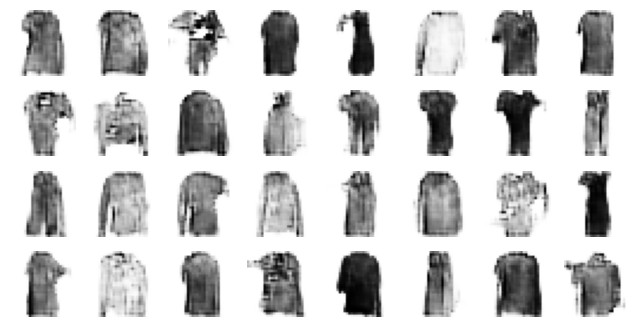

Epoch 2/5


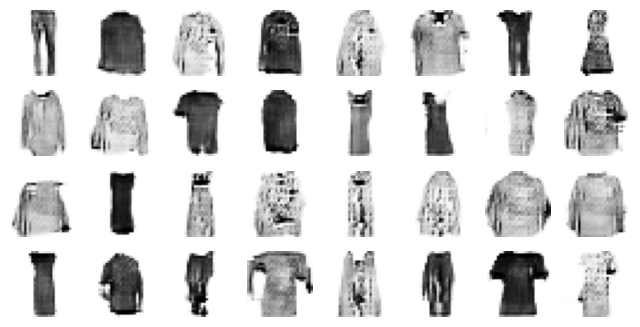

Epoch 3/5


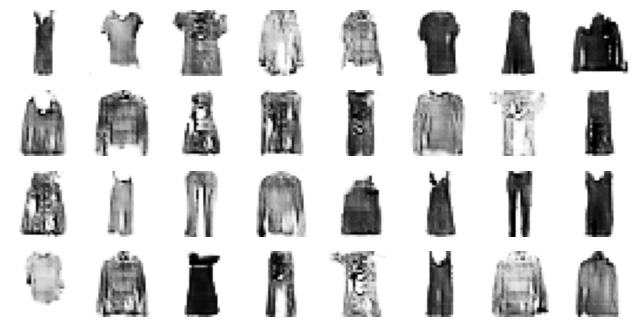

Epoch 4/5


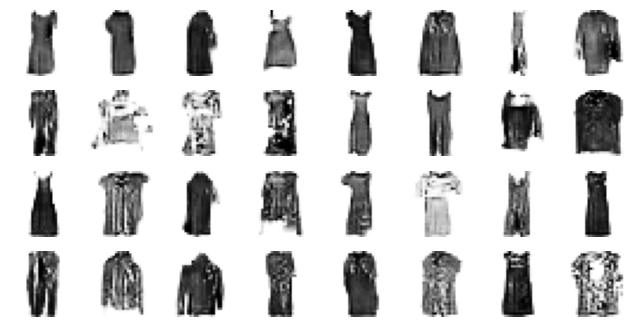

Epoch 5/5


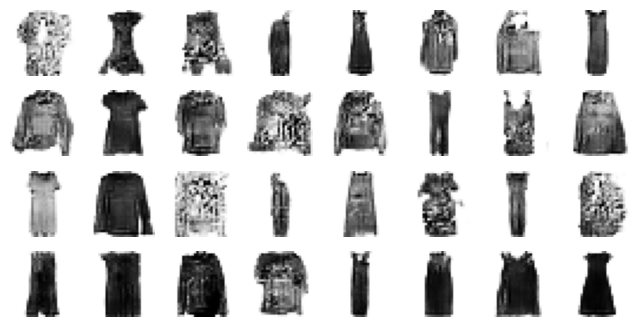

In [12]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=5)

**Exercise:** What do you observe in the images above? What seems to work well, what not?

**Solution:**
- Some of the labels occur very rarely, for example there are no bags or shoes in these images. This is called **Mode Collapse**, as the generator seems to work well for dresses and trousers, and then switches to these types of cloth. This could be addressed by discriminating a batch of images.
- The GAN seems to oscillate around, producing mostly light colors in epoch 3, and then mostly dark ones in epoch 5. Hence, the model parameters are not stable, as it's an ongoing "battle" between the two models.



**Exercise:** Can you get similar results with less parameters? Play around with the models, and report your findings.